In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
img = cv2.imread("test_image/solidWhiteCurve.jpg")

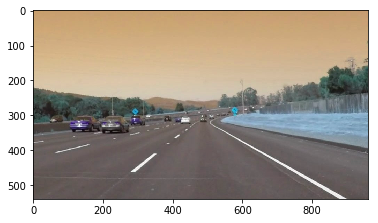

In [3]:
plt.imshow(img, cmap=None)

In [4]:
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

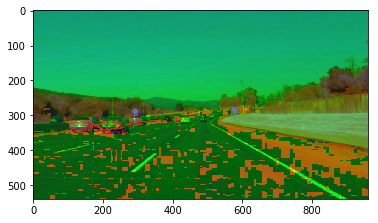

In [5]:
plt.imshow(hls, cmap=None)

In [6]:
def color_filter(image):
    #convert to HLS to mask based on HLS
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    lower = np.array([0,190,0])
    upper = np.array([255,255,255])
    yellower = np.array([10,0,90])
    yelupper = np.array([50,255,255])
    yellowmask = cv2.inRange(hls, yellower, yelupper)
    whitemask = cv2.inRange(hls, lower, upper)
    mask = cv2.bitwise_or(yellowmask, whitemask)
    masked = cv2.bitwise_and(image, image, mask = mask)
    return masked

In [7]:
filtered_img=color_filter(img)

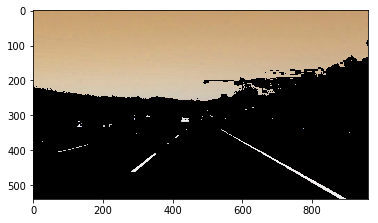

In [8]:
plt.imshow(filtered_img, cmap=None)

In [9]:
def roi(img):
    x = int(img.shape[1])
    y = int(img.shape[0])
    shape = np.array([[int(0), int(y)], [int(x), int(y)], [int(0.55*x), int(0.6*y)], [int(0.45*x), int(0.6*y)]])
    #define a numpy array with the dimensions of img, but comprised of zeros
    mask = np.zeros_like(img)
    #Uses 3 channels or 1 channel for color depending on input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    #creates a polygon with the mask color
    cv2.fillPoly(mask, np.int32([shape]), ignore_mask_color)
    #returns the image only where the mask pixels are not zero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [10]:
roi_img=roi(filtered_img)

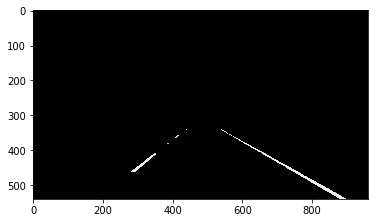

In [11]:
plt.imshow(roi_img, cmap=None)

In [12]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
def canny(img):
    return cv2.Canny(grayscale(img), 50, 120)

In [13]:
canny_img=canny(roi_img)

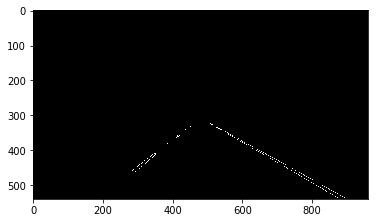

In [14]:
plt.imshow(canny_img, cmap='gray')

In [23]:
rightSlope, leftSlope, rightIntercept, leftIntercept = [],[],[],[]
def draw_lines(img, lines, thickness=5):
    global rightSlope, leftSlope, rightIntercept, leftIntercept
    rightColor=[0,255,0]
    leftColor=[255,0,0]
    
    #this is used to filter out the outlying lines that can affect the average
    #We then use the slope we determined to find the y-intercept of the filtered lines by solving for b in y=mx+b
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y1-y2)/(x1-x2)
            if slope > 0.3:
                if x1 > 500 :
                    yintercept = y2 - (slope*x2)
                    rightSlope.append(slope)
                    rightIntercept.append(yintercept)
                else: None
            elif slope < -0.3:
                if x1 < 600:
                    yintercept = y2 - (slope*x2)
                    leftSlope.append(slope)
                    leftIntercept.append(yintercept)
    #We use slicing operators and np.mean() to find the averages of the 30 previous frames
    #This makes the lines more stable, and less likely to shift rapidly
    leftavgSlope = np.mean(leftSlope[-30:])
    leftavgIntercept = np.mean(leftIntercept[-30:])
    rightavgSlope = np.mean(rightSlope[-30:])
    rightavgIntercept = np.mean(rightIntercept[-30:])
    #Here we plot the lines and the shape of the lane using the average slope and intercepts
    try:
        left_line_x1 = int((0.65*img.shape[0] - leftavgIntercept)/leftavgSlope)
        left_line_x2 = int((img.shape[0] - leftavgIntercept)/leftavgSlope)
        right_line_x1 = int((0.65*img.shape[0] - rightavgIntercept)/rightavgSlope)
        right_line_x2 = int((img.shape[0] - rightavgIntercept)/rightavgSlope)
        pts = np.array([[left_line_x1, int(0.65*img.shape[0])],[left_line_x2, int(img.shape[0])],[right_line_x2, int(img.shape[0])],[right_line_x1, int(0.65*img.shape[0])]], np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.fillPoly(img,[pts],(0,0,255))
        cv2.line(img, (left_line_x1, int(0.65*img.shape[0])), (left_line_x2, int(img.shape[0])), leftColor, 10)
        cv2.line(img, (right_line_x1, int(0.65*img.shape[0])), (right_line_x2, int(img.shape[0])), rightColor, 10)
    except ValueError:
    #I keep getting errors for some reason, so I put this here. Idk if the error still persists.
        pass
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img
def linedetect(img):
    return hough_lines(img, 1, np.pi/180, 10, 20, 100)


In [24]:
hough_img = linedetect(canny_img)

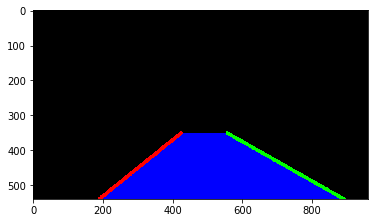

In [25]:
plt.imshow(hough_img, cmap=None)


In [26]:
type(img)

numpy.ndarray

In [27]:
def weightSum(input_set):
    img = list(input_set)
    return cv2.addWeighted(img[0], 1, img[1], 0.8, 0)

In [28]:
result_img = weightSum([hough_img, img])

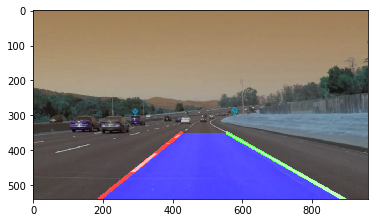

In [29]:
plt.imshow(result_img, cmap=None)